In [1]:
from src.data.eeg_measurement import EegMeasurement
from src.data.eeg_attention_pytorch_dataset import EegAttentionDataset
from src.evaluation.eval_vanilla_ridge import RidgeEvaluator
import numpy as np
import git
import os
import pandas
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.collections import LineCollection
import scipy
import pickle
from scipy.stats import ttest_rel

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
base_dir = git.Repo('.', search_parent_directories=True).working_tree_dir

model_ids: {'007': 'Raw EEG + envelope feature',
            '024': 'Pretrained CNN: Raw EEG + envelope'}

labels = ['1: Ridge: Raw EEG + envelope feature',
            '2: Pretrained CNN: Raw EEG + envelope']

c_cnn = '#1f77b4'
c_ridge = '#ff7f0e'

subjects = list(range(102,115))
subjects = subjects + list(range(116,117))
subjects = subjects + list(range(118,126))
subjects = subjects + [127, 128, 130]

fig_path = os.path.join(base_dir, 'reports', 'figures', 'complete_dataset')

# Define paths

In [3]:
#accuracies
ridge_acc_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/020/windowed_accuracies/windowed_accuracies020.npy'
ridge_ica_acc_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/021/windowed_accuracies/windowed_accuracies021.npy'
ridge_onset_acc_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/022/windowed_accuracies/windowed_accuracies022.npy'
ridge_onset_ica_acc_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/023/windowed_accuracies/windowed_accuracies023.npy'


cnn_pre_acc_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/060/overall_acc60.npy'
cnn_subj_acc_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/061/overall_acc61.npy'
#second config of pretraining
cnn_pre_acc_path_2 = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/152pickled_raw/accuracies.pkl'
cnn_subj_acc_path_2 = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/153pickled_raw/accuracies.pkl'

#all without pretraining
cnn_ica_acc_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/176pickled_raw/accuracies.pkl'
cnn_onset_acc_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/186pickled_raw/accuracies.pkl'
cnn_onset_ica_acc_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/196pickled_raw/accuracies.pkl'

#r_attended
ridge_r_attended_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/020/windowed_accuracies/windowed_attended_scores_averaged020.npy'
ridge_ica_r_attended_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/021/windowed_accuracies/windowed_attended_scores_averaged021.npy'
ridge_onset_r_attended_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/022/windowed_accuracies/windowed_attended_scores_averaged022.npy'
ridge_onset_ica_r_attended_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/023/windowed_accuracies/windowed_attended_scores_averaged023.npy'

cnn_pre_r_attended_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/060/overall_r_attended60.npy'
cnn_subj_r_attended_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/061/overall_r_attended61.npy'

#r_distractor
ridge_r_distractor_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/020/windowed_accuracies/windowed_distractor_scores_averaged020.npy'
ridge_ica_r_distractor_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/021/windowed_accuracies/windowed_distractor_scores_averaged021.npy'
ridge_onset_r_distractor_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/022/windowed_accuracies/windowed_distractor_scores_averaged022.npy'
ridge_onset_ica_r_distractor_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/023/windowed_accuracies/windowed_distractor_scores_averaged023.npy'

cnn_pre_r_distractor_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/060/overall_r_distractor60.npy'
cnn_subj_r_distractor_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/061/overall_r_distractor61.npy'

## Load data

In [4]:
#accuracies
ridge_acc = np.load(ridge_acc_path)
#due to differnet evaluation loops reshaping is necessary
#ridge_acc = np.moveaxis(ridge_acc, 0, -1)

ridge_ica_acc = np.load(ridge_ica_acc_path)
#ridge_ica_acc = np.moveaxis(ridge_ica_acc, 0, -1)

ridge_onset_acc = np.load(ridge_onset_acc_path)
#ridge_onset_acc = np.moveaxis(ridge_onset_acc, 0, -1)

ridge_onset_ica_acc = np.load(ridge_onset_ica_acc_path)
#ridge_onset_ica_acc = np.moveaxis(ridge_onset_ica_acc, 0, -1)

cnn_acc_pretrained = np.load(cnn_pre_acc_path)
cnn_acc_subj = np.load(cnn_subj_acc_path)

with open(cnn_ica_acc_path, 'rb') as f:
    cnn_ica_acc = pickle.load(f)
with open(cnn_onset_acc_path, 'rb') as f:
    cnn_onset_acc = pickle.load(f)
with open(cnn_onset_ica_acc_path, 'rb') as f:
    cnn_onset_ica_acc = pickle.load(f)

with open(cnn_pre_acc_path_2, 'rb') as f:
    cnn_acc_pretrained_2 = pickle.load(f)
    cnn_acc_pretrained_2 = np.array(cnn_acc_pretrained_2)
with open(cnn_subj_acc_path_2, 'rb') as f:
    cnn_acc_subj_2 = pickle.load(f)
    cnn_acc_subj_2 = np.array(cnn_acc_subj_2)

In [5]:
#r_attended
ridge_r_attended = np.load(ridge_r_attended_path)
#ridge_r_attended = np.moveaxis(ridge_r_attended, 0, -1)

ridge_ica_r_attended = np.load(ridge_ica_r_attended_path)
#ridge_ica_r_attended = np.moveaxis(ridge_ica_r_attended, 0, -1)

ridge_onset_r_attended = np.load(ridge_onset_r_attended_path)
#ridge_onset_r_attended = np.moveaxis(ridge_onset_r_attended, 0, -1)

ridge_onset_ica_r_attended = np.load(ridge_onset_ica_r_attended_path)
#ridge_onset_ica_r_attended = np.moveaxis(ridge_onset_ica_r_attended, 0, -1)

cnn_r_attended_pretrained = np.load(cnn_pre_r_attended_path)
cnn_r_attended_subj = np.load(cnn_subj_r_attended_path)

In [6]:
#r_distractor
ridge_r_distractor = np.load(ridge_r_distractor_path)
ridge_r_distractor = np.moveaxis(ridge_r_distractor, 0, -1)

ridge_ica_r_distractor = np.load(ridge_ica_r_distractor_path)
ridge_ica_r_distractor = np.moveaxis(ridge_ica_r_distractor, 0, -1)

ridge_onset_r_distractor = np.load(ridge_onset_r_distractor_path)
ridge_onset_r_distractor = np.moveaxis(ridge_onset_r_distractor, 0, -1)

ridge_onset_ica_r_distractor = np.load(ridge_onset_ica_r_distractor_path)
ridge_onset_ica_r_distractor = np.moveaxis(ridge_onset_ica_r_distractor, 0, -1)

cnn_r_distractor_pretrained = np.load(cnn_pre_r_distractor_path)
cnn_r_distractor_subj = np.load(cnn_subj_r_distractor_path)

# Generate value arrays for analysis

In [7]:
#60s mean accuracy
ridge_subj_acc_60 = np.mean(ridge_acc, axis=(1))[:,0]
ridge_ica_subj_acc_60 = np.mean(ridge_ica_acc, axis=(1))[:,0]
ridge_onset_subj_acc_60 = np.mean(ridge_onset_acc, axis=(1))[:,0]
ridge_onset_ica_subj_acc_60 = np.mean(ridge_onset_ica_acc, axis=(1))[:,0]

cnn_pre_subj_acc_60 = np.mean(cnn_acc_pretrained, axis=(1))[:,0]
cnn_subj_subj_acc_60 = np.mean(cnn_acc_subj, axis=(1))[:,0]
cnn_ica_acc_60 = np.mean(cnn_ica_acc, axis=(1))[:,0]
cnn_onset_acc_60 = np.mean(cnn_onset_acc, axis=(1))[:,0]
cnn_onset_ica_acc_60 = np.mean(cnn_onset_ica_acc, axis=(1))[:,0]

#second config of pretraining
cnn_pre_2_subj_acc_60 = np.mean(cnn_acc_pretrained_2, axis=(1))[:,0]
cnn_subj_2_subj_acc_60 = np.mean(cnn_acc_subj_2, axis=(1))[:,0]

#values for 30, 10, 5
ridge_subj_acc_30 = np.mean(ridge_acc, axis=(1))[:,2]
cnn_pre_subj_acc_30 = np.mean(cnn_acc_pretrained, axis=(1))[:,2]
cnn_subj_subj_acc_30 = np.mean(cnn_acc_subj, axis=(1))[:,2]

ridge_subj_acc_10 = np.mean(ridge_acc, axis=(1))[:,4]
cnn_pre_subj_acc_10 = np.mean(cnn_acc_pretrained, axis=(1))[:,4]
cnn_subj_subj_acc_10 = np.mean(cnn_acc_subj, axis=(1))[:,4]

ridge_subj_acc_5 = np.mean(ridge_acc, axis=(1))[:,5]
cnn_pre_subj_acc_5 = np.mean(cnn_acc_pretrained, axis=(1))[:,5]
cnn_subj_subj_acc_5 = np.mean(cnn_acc_subj, axis=(1))[:,5]

#get mean and sem over different window lengths
acc_window_sizes = np.array([60,45,30,20,10,5,2,1])

window_accuracies_ridge = np.mean(ridge_acc,axis=(0,1))
window_sem_rige = scipy.stats.sem(ridge_acc,axis=(0,1))

window_accuracies_cnn = np.mean(cnn_acc_pretrained,axis=(0,1))
window_sem_cnn = scipy.stats.sem(cnn_acc_pretrained,axis=(0,1))

window_accuracies_cnn_subj = np.mean(cnn_acc_subj,axis=(0,1))
window_sem_cnn_subj = scipy.stats.sem(cnn_acc_subj,axis=(0,1))

#window means for individual subjects
per_subject_window_accuracies_ridge = np.mean(ridge_acc,axis=(1))
per_subject_window_sem_rige = scipy.stats.sem(ridge_acc,axis=(1))

per_subject_window_accuracies_cnn = np.mean(cnn_acc_pretrained,axis=(1))
per_subject_window_sem_cnn = scipy.stats.sem(cnn_acc_pretrained,axis=(1))

In [8]:
def adjust_boxplot(box_plot, line_width, flier_marker=None, colors=None):
    for med in box_plot['medians']:
        med.set_color('black')
    for box in box_plot['boxes']:
        box.set_linewidth(line_width)
        box.set_color('black')
    for whisker in box_plot['whiskers']:
        whisker.set_linewidth(line_width)
        whisker.set_color('black')
    for cap in box_plot['caps']:
        cap.set_linewidth(line_width)
        cap.set_color('black')
    if colors is not None:
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)
    return box_plot

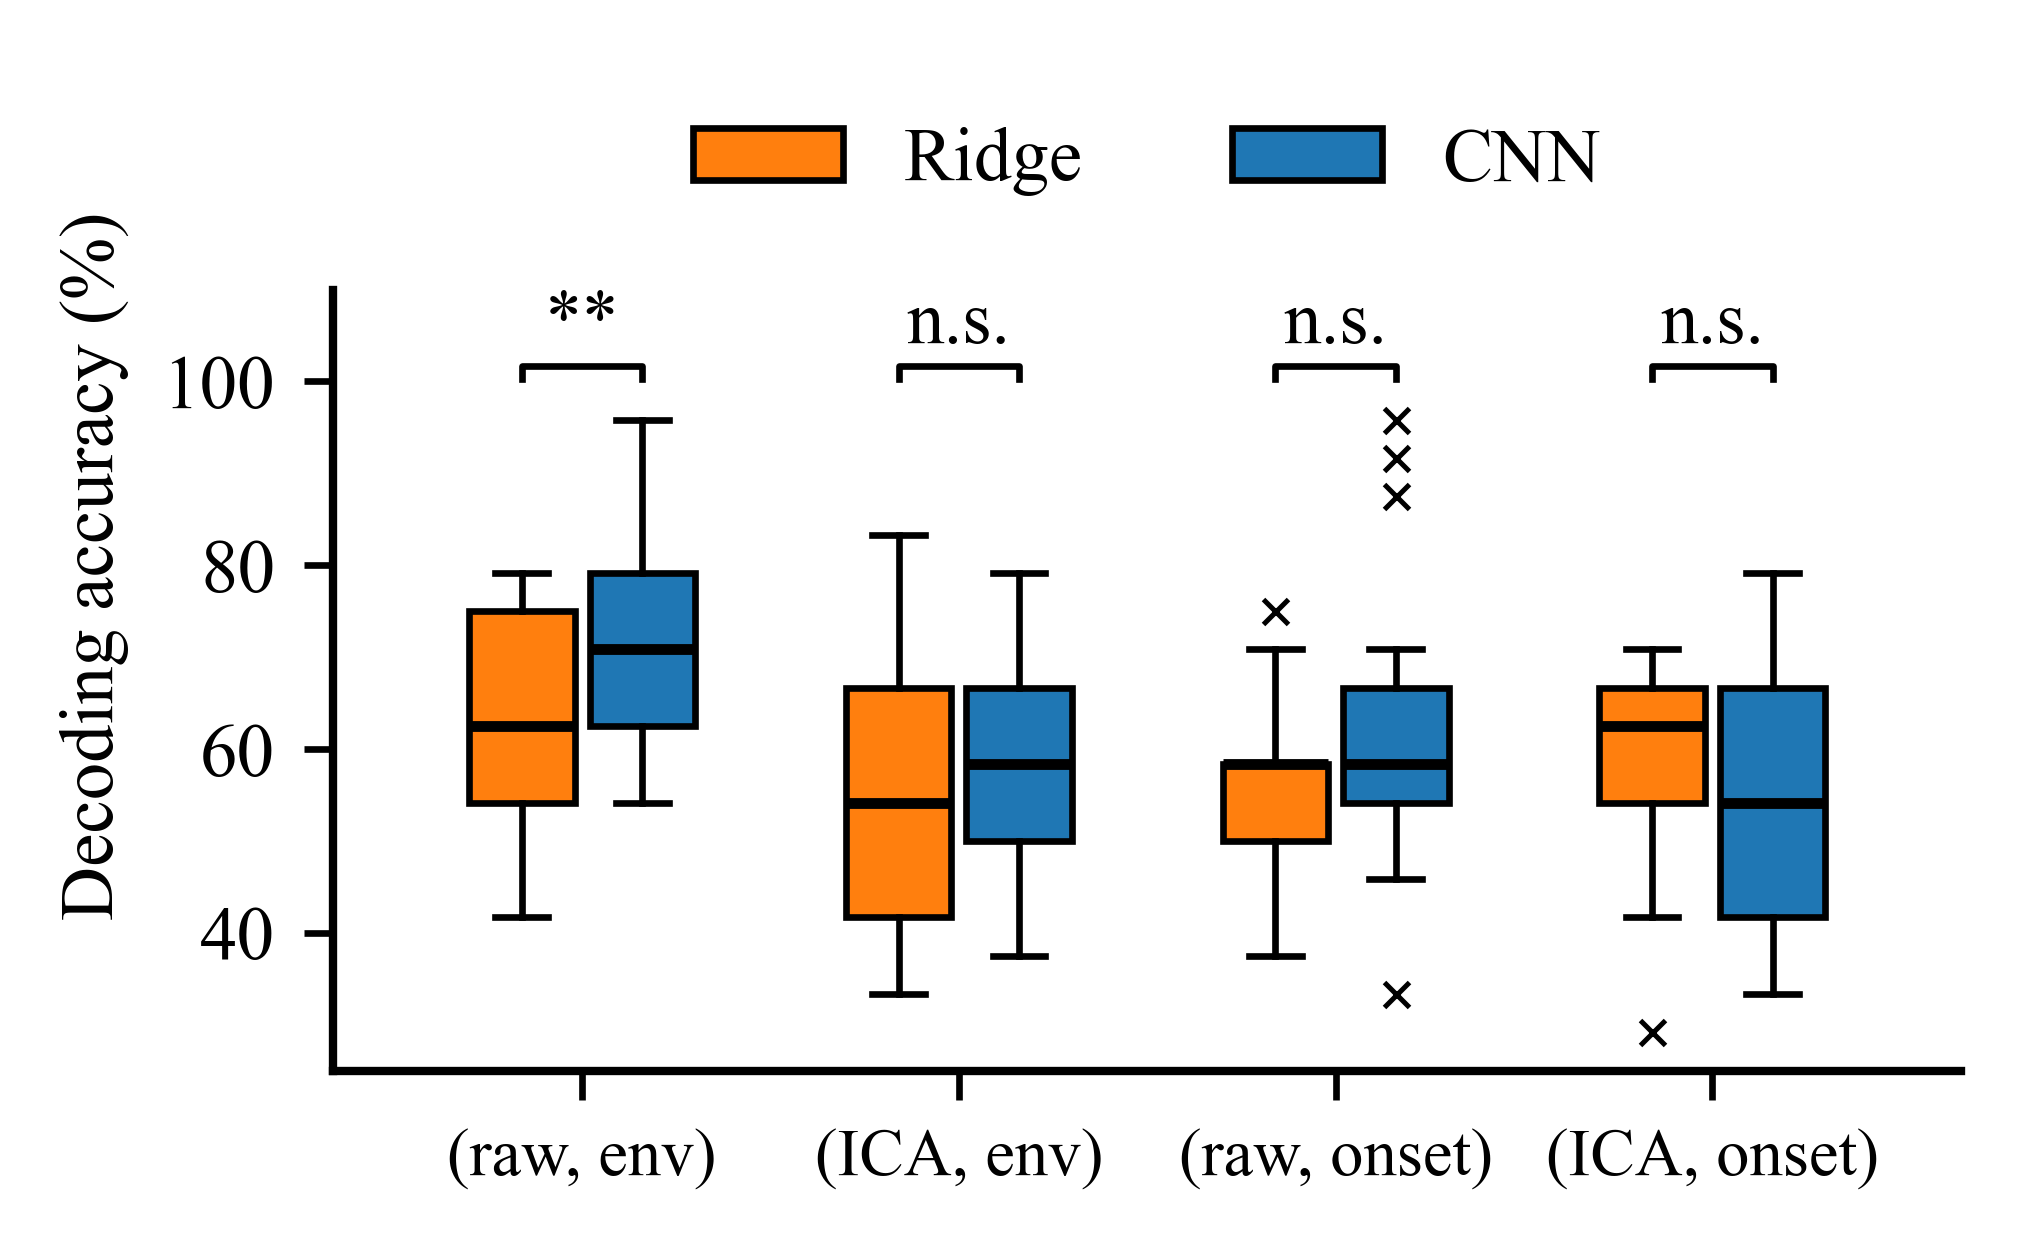

In [9]:
box_plot_widts = 0.28
box_plot_line_width = 0.8
box_plot_colors = [c_ridge, c_cnn, c_ridge, c_cnn, c_ridge, c_cnn, c_ridge, c_cnn]
flierprops = dict(marker='x', markerfacecolor='k', markersize=3, markeredgewidth=0.6)
boxprops = dict(linestyle='-', linewidth=box_plot_line_width, color='darkgoldenrod')

box_plot_flier_marker = 'x'
positions = np.array([[i-(box_plot_widts/2 + 0.02), i+(box_plot_widts/2 + 0.02)] for i in range(1,5)]).flatten()

scatter_delta = 0.06
marker = 'o'
marker_size = 10
tick_fontsize = 9
label_fontsize = 9
labels = ['(raw, env)', '(ICA, env)', '(raw, onset)', '(ICA, onset)']
legend_fontsize = 9
plt.rcParams["font.family"] = "Times New Roman"

box_plot_data = np.vstack((ridge_subj_acc_60.flatten(),cnn_subj_2_subj_acc_60.flatten(),
                            ridge_ica_subj_acc_60.flatten(), cnn_ica_acc_60.flatten(),
                            ridge_onset_subj_acc_60.flatten(), cnn_onset_acc_60.flatten(), 
                            ridge_onset_ica_subj_acc_60.flatten(), cnn_onset_ica_acc_60.flatten())).T

significances = [ttest_rel(ridge_subj_acc_60.flatten(),cnn_subj_2_subj_acc_60.flatten()),
                 ttest_rel(ridge_ica_subj_acc_60.flatten(), cnn_ica_acc_60.flatten()),
                 ttest_rel(ridge_onset_subj_acc_60.flatten(), cnn_onset_acc_60.flatten()),
                 ttest_rel(ridge_onset_ica_subj_acc_60.flatten(), cnn_onset_ica_acc_60.flatten())]
p_vals = [s[1] for s in significances]

fig, ax = plt.subplots(figsize=(3.5,5/(8/3.5)), dpi=600)
box_plot = ax.boxplot(box_plot_data, positions=positions, widths=box_plot_widts, patch_artist=True, showfliers=True, flierprops=flierprops, medianprops={"linewidth": box_plot_line_width + 0.5,
                        "solid_capstyle": "butt"})
box_plot = adjust_boxplot(box_plot, box_plot_line_width, flier_marker=box_plot_flier_marker, colors=box_plot_colors)

bottom, top = ax.get_ylim()
y_range = top - bottom
#significance bars
for i, p in zip(range(0, len(p_vals)), p_vals):
    x_0 = positions[i*2]
    x_1 = positions[i*2+1]
    level = 0.5
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    ax.plot([x_0, x_0, x_1, x_1], [bar_tips, bar_height, bar_height, bar_tips], lw=box_plot_line_width, c='k')
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'n.s.'

    text_height = bar_height + (y_range * 0.01)
    plt.text((x_0 + x_1)/2, text_height, sig_symbol, ha='center', va='bottom', color='k', fontsize=tick_fontsize)

#scatter plot
# for i in range(8):
#     color = c_ridge if i % 2 == 0 else c_cnn
#     ax.scatter(np.linspace(-scatter_delta, scatter_delta,box_plot_data.shape[0]) + positions[i], box_plot_data[:,i], marker=marker, color='k', alpha=1, s=marker_size)
ax.set_xticks([i for i in range(1,5)])
ax.set_xticklabels(labels, rotation=0, fontsize = tick_fontsize-1)
#ax.set_xlabel('\n(EEG, Speech feature)', fontsize = label_fontsize)
ax.set_ylabel('Decoding accuracy (%)', fontsize = label_fontsize)
ax.set_yticks([0.4, 0.6, 0.8, 1.0])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0, symbol=None))
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.set_ylim([0.25, 1.35])
ax.legend([box_plot["boxes"][0], box_plot["boxes"][1]], ['Ridge', 'CNN'], loc='upper center', fontsize=legend_fontsize, ncols = 2, frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds(0.25, 1.1)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)

fig_path = os.path.join(base_dir, 'reports', 'figures', 'complete_dataset', 'ridge_vs_cnn_60s_acc_boxplot')
extensions = ['.png', '.svg', '.pdf']
for ext in extensions:
    fig.savefig(fig_path + ext, bbox_inches='tight', dpi=600)